[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/accessing_GMF_components.ipynb)

# Accessing the GMF components

In this tutorial, we show how to access the different magnetic field components of the models of the Galactic magnetic field from <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar (2012)</a>, <a href="https://ui.adsabs.harvard.edu/abs/2011ApJ...738..192P/abstract">Pshirkov et al. (2011)</a> and <a href="https://ui.adsabs.harvard.edu/abs/2024ApJ...970...95U/abstract">Unger & Farrar (2024)</a>.

We begin with the necessary imports and defining a grid in galacto-centric coordinates.

In [1]:
from gammaALPs.bfields import gmf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

fatal: No names found, cannot describe anything.


First we build 3D coordinate arrays in galactocentric cartesian ($x, y, z$) and cylindrical coordinates $(\rho, \phi, z)$, where $x, y, z$ and $\rho$ are in units of kpc. 

In [2]:
x = np.linspace(-20.,20.,300)
y = np.linspace(-20.,20.,300)
z = np.arange(-5.,5.01,0.01)
xx, yy, zz = np.meshgrid(x, y, z, indexing = 'ij')

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

## The Pshirkov model

For the Pshirkov model, both the bisymmetric (BSS) and the axisymmetric (ASS) versions are available.
We illustrate the model and its usage for the ASS version.

The model is simply initialized like this:

In [3]:
pshirkov = gmf.GMFPshirkov(model='ASS')

The model has two $B$-field components: the field in the halo and in the disk. To show the disk component, we select the $z$ component that is closest to $z=0$:

In [4]:
idz = np.argmin(np.abs(z))

Then we calculate and plot the disk component through the `Bdisk` function. 
We multiply the abolute value of the field with the `gmf.signum` function to determine the sign of the $B$-field relative to the $z=0$ plane.

In [5]:
Bdisk = np.zeros_like(rr[...,idz])

for i, r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is absolute value
    b = pshirkov.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

And plot the results:

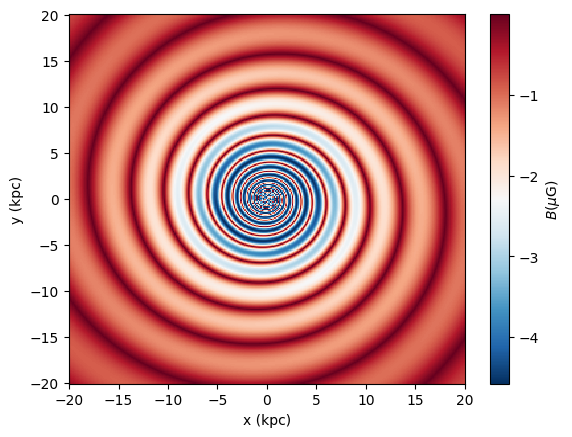

In [6]:
im = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap=plt.cm.RdBu_r, shading='auto')
plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

We proceed similarly for the halo component by finding the index where $y = 0$ (or closest to it):

In [7]:
idy = np.argmin(np.abs(y))

And calculate the halo component in the same way as the disk component:

In [8]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = pshirkov.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[i,:] = b[1]

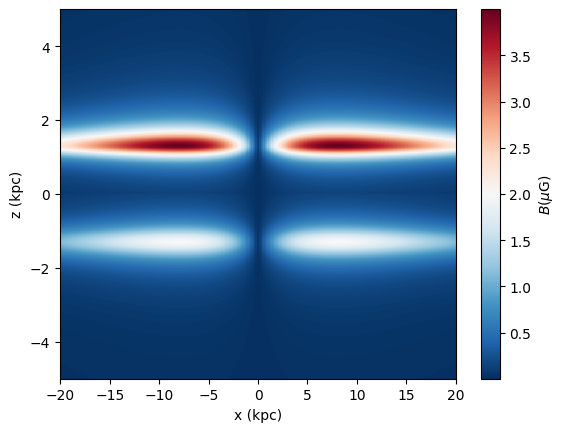

In [9]:
im = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.RdBu_r, shading='auto')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

The total magnetic field would then be found by summing the `Bdisk` and `Bhalo` vectors (evaluated over the same coordinate grid). 

## The Jansson & Farrar model

We follow the same steps for the Jansson & Farrar model. The only difference here is that this model has an additional "X" component which we will plot as well. 

We initiate the class like this:

In [10]:
jansson = gmf.GMF()

Print the magnetic field in the 8th ring, which is given by $b_8 = \sum_{i=1}^7 b_i f_i / f_8$, where the $f_i$ is relative cross-sectional areas of the spirals (for a fixed radius) and $b_i$ is the mangetic field in each spiral arm (see <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...757...14J/abstract">Jansson & Farrar (2012)</a>, Sec. 5.1.1).

In [11]:
print (jansson.b[7])

2.755128205128205


Now calculate the disk component:

In [12]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    b = jansson.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

And for some specific positions, at which we want to place arrows in the plot

In [13]:
# position of arrows in plot
rho0 = np.array([4., 5.5, 6.5, 8., 9., 10.5, 12, 16.5])
phi0 = np.array([5. * np.pi / 4.])

Bdisk_arrow = np.zeros([3, rho0.size])
for i, r in enumerate(rho0):
    b = jansson.Bdisk(np.array([r]), phi0, z=z[idz])[0]
    Bdisk_arrow[:,i] = b[:,0]
    
# now transform Bdisk_arrow components (rho, phi, z)
# to cartesian coordinates
Bdisk_x = np.zeros_like(Bdisk_arrow)  # disk component in cartesian coordinates
Bdisk_x[0] = np.cos(phi0) * Bdisk_arrow[0] - np.sin(phi0) * Bdisk_arrow[1]
Bdisk_x[1] = np.sin(phi0) * Bdisk_arrow[0] + np.cos(phi0) * Bdisk_arrow[1]
Bdisk_x[2] = Bdisk_arrow[2]

Plotting it:

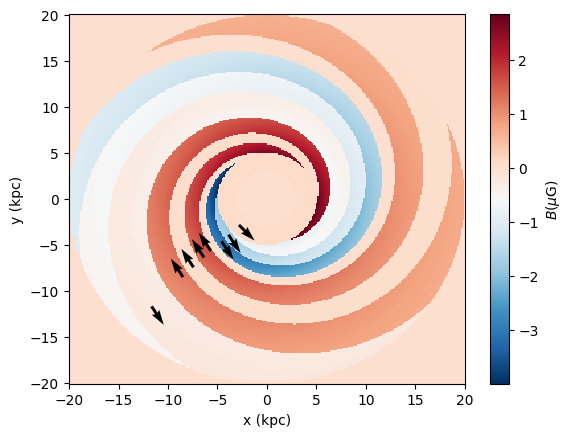

In [14]:
im = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, cmap=plt.cm.RdBu_r, shading='auto')

# the arrows
plt.quiver(rho0 * np.cos(phi0), rho0 * np.sin(phi0),
           Bdisk_x[0] / np.sqrt(np.sum(Bdisk_x**2., axis = 0)),
           Bdisk_x[1] / np.sqrt(np.sum(Bdisk_x**2., axis = 0)),
          )

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

Proceeding with the halo component in the same way as before:

In [15]:
Bhalo = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.Bhalo(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    Bhalo[i,:] = b[1]

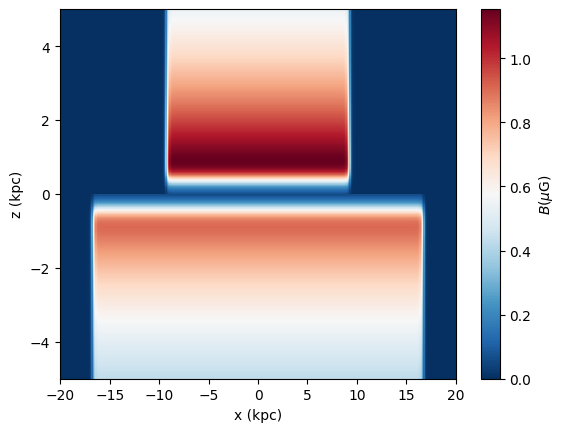

In [16]:
im = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo, cmap=plt.cm.RdBu_r, shading='auto')
plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(im, label = '$B (\mu\mathrm{G})$')

And the additional "X" component:

In [17]:
BX_abs = np.zeros_like(xx[:,idy,:])
BX = np.zeros([3] + list(xx[:,idy,:].shape))

for i,xi in enumerate(xx[:,idy,:]):
    b = jansson.BX(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]
    
# now transform Bdisk_arrow components (rho, phi, z)
# to cartesian coordinates
# note that phi component is zero
BX_x = BX[0] * np.cos(pp[:,idy,...])
BX_y = BX[0] * np.sin(pp[:,idy,...])

BX_z = BX[2]

/tmp/ipykernel_209855/2324834406.py:8: RuntimeWarning: invalid value encountered in divide
  BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
/tmp/ipykernel_209855/2324834406.py:15: RuntimeWarning: invalid value encountered in divide
  BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],


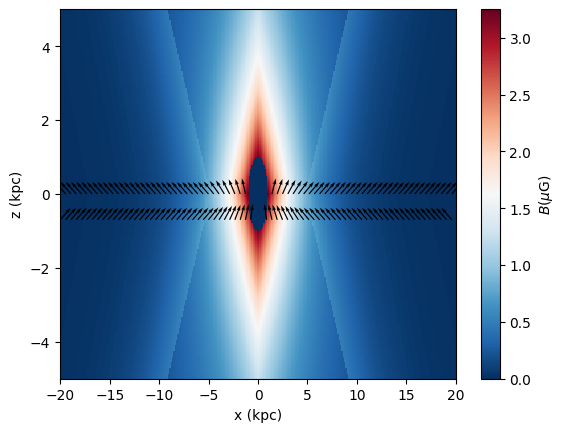

In [18]:
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX_abs, cmap=plt.cm.RdBu_r, shading='auto')

# plot the arrows
# at z = 0
idz = int(len(z) / 2)
step = 4
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

# arrows below disk
idz = int(len(z) / 2) - 70
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abs[:,idz][::step], BX_z[:,idz][::step] / BX_abs[:,idz][::step],
           width=3e-3, scale=25
          )

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

Again, the total magnetic field would be found by summing the `Bdisk`, `Bhalo`, and `BX` vectors evaluated over the same coordinate grid. 

## The Unger & Farrar model (UF23)

The UF23 Model consists of a set of eight models that can be constructed with five different components. The different components can be accessed similarly to the Pshirkov and JF12 model.

In [19]:
models = ['base', 'expX', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', 'spur']

In [20]:
x = np.linspace(-20.,20.,200)
y = np.linspace(-20.,20.,200)
z = np.arange(-5.,5.01,0.05)
xx, yy, zz = np.meshgrid(x, y, z, indexing = 'ij')

rr = np.sqrt(xx ** 2. + yy ** 2.) # rho component
pp = np.arctan2(yy, xx) # phi component

For the disk field there are two components implemented. The grand fourier spiral is used in 7 of the 8 models (we use the "base" model as example) and the spiral spur field is used in the "spur" model.

### Fourier Spiral

We initialize the class for the 'base' model:

In [21]:
uf23 = gmf.UF23(model='base')

We calculate the $B$-Field at $z = 0$

In [22]:
zplot = 0
idz = np.absolute(z-zplot).argmin()

Now we calculate the fourier-spiral disk field

In [23]:
Bdisk = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field vector, second entry is abs value
    b = uf23.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz]) 
    # same as uf23.spiral_field(...)
    Bdisk[:,i] = b[1] * gmf.signum(b[0][1,:])

Instead of `uf23.Bdisk()`, we could also use `uf23.spiral_field()`. `Bdisk()` just chooses between `spiral_field()` and `spur_field()` depending on the chosen model.

Plotting:

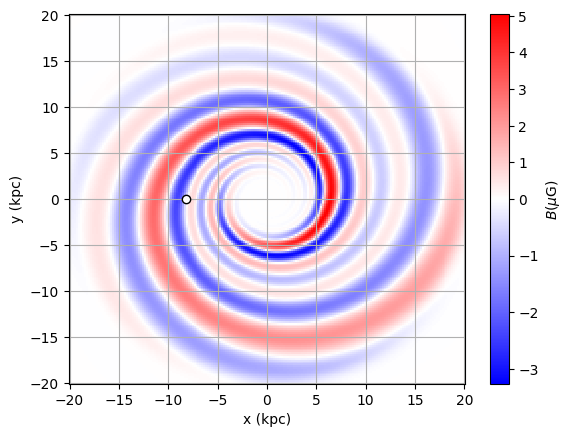

In [24]:
norm = TwoSlopeNorm(vmin=Bdisk.min(), vcenter=0, vmax=Bdisk.max())
p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk, norm=norm, cmap = plt.cm.bwr, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

# position of sun
plt.plot(-8.2, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

### Spiral Spur

The spiral spur component is only used in the "spur" model. So we initialize the class with the other model and calculate again the disk field using the same function as above.

In [25]:
spur = gmf.UF23(model='spur')

In [26]:
Bdisk_spur = np.zeros_like(rr[...,idz])
for i,r in enumerate(rr[...,idz]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = spur.Bdisk(rho=r, phi=pp[:,i,idz], z=zz[:,i,idz])
    # same as spur.spiral_spur(...)
    Bdisk_spur[:,i] = b[1] * gmf.signum(b[0][1,:])

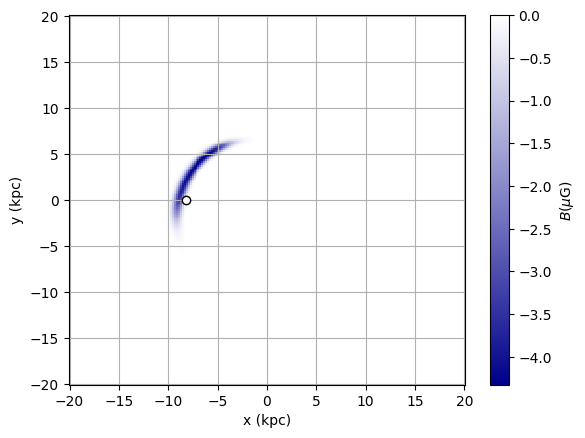

In [27]:
cmap0 = LinearSegmentedColormap.from_list('', ['darkblue', 'white'])

p = plt.pcolormesh(xx[...,idz], yy[...,idz], Bdisk_spur, cmap = cmap0, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

# position of sun
plt.plot(-8.2, 0., marker='o', mec='k', mfc='w')
plt.grid()

plt.show()

## Halo Field

For the Halo field there are three components implemented: `toroidal_halo_field()`, `poloidal_halo_field()`, and `twisted_halo_field()`.
Seven of the 8 models use the sum of the toroidal and poloidal halo field, and the "twistX" model uses the `twisted_halo_field()`. The function `Bhalo()` would return either the sum of toroidal and poloidal halo field or the twisted halo field depending on the chosen model.

The components can also be accessed seperately:

### Toroidal Halo

We calculate the toroidal halo in the $x$-$z$-plane at $y=0$

In [28]:
yplot = 0
idy = np.absolute(y-yplot).argmin()

We use again the "base" model for example and do a similar calculation:

In [29]:
Bhalo_tor = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    # returns (3,N),(N) tuple, first entry is field, second entry is abs value
    b = uf23.toroidal_halo_field(rho=np.sqrt(xi**2. + y[idy]**2.), z=zz[i,idy,:]) 
    Bhalo_tor[i,:] = b[1] * gmf.signum(b[0][1,:])

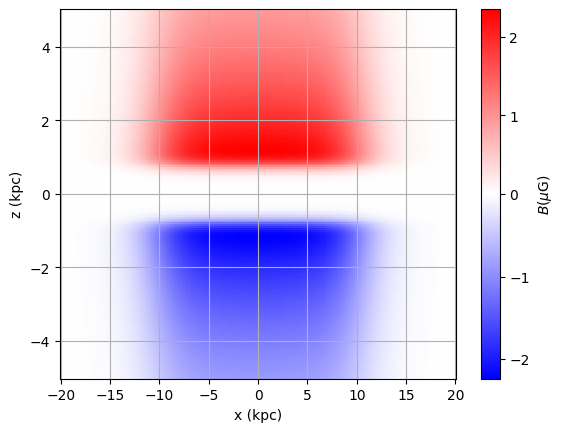

In [30]:
norm = TwoSlopeNorm(vmin=Bhalo_tor.min(), vcenter=0, vmax=Bhalo_tor.max())
p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], Bhalo_tor, norm=norm, cmap = plt.cm.bwr, shading='auto')

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

plt.grid()

plt.show()

### Poloidal Halo

Additionally to the torodial halo field, the UF23 model contains a poloidal halo component, similar to the X-Field in the JF12 model. The poloidal component has two functions for the radial dependence, depending on the chosen model. For the "expX" model a exponential function is used, while the other models use a sigmoid function.
For the "base" model we get:

In [31]:
BX = np.zeros([3] + list(xx[:,idy,:].shape))
BX_abs = np.zeros_like(xx[:,idy,:])
for i,xi in enumerate(xx[:,idy,:]):
    b = uf23.poloidal_halo_field(rho=np.sqrt(xi**2. + y[idy]**2.),
                       z=zz[i,idy,:]) 
    BX_abs[i,:] = b[1]
    BX[:, i, :] = b[0]

# convert to cartesian coordinates, phi component is zero
BX_x = BX[0] * np.cos(pp[:,idy,...])
BX_y = BX[0] * np.sin(pp[:,idy,...])
BX_z = BX[2]
BX_abss = np.where(BX_abs == 0, 1e-24, BX_abs)

Plot with arrows:

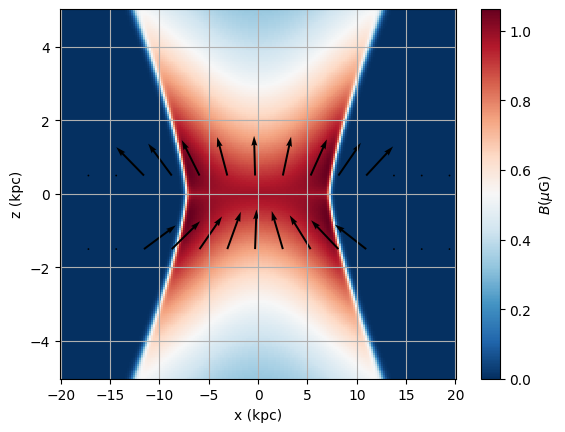

In [32]:
cmap0 = LinearSegmentedColormap.from_list('', ['white', 'red'])

p = plt.pcolormesh(xx[:,idy,:], zz[:,idy,:], BX_abs, cmap=plt.cm.RdBu_r, shading='auto')

plt.colorbar(p, label = '$B (\mu\mathrm{G})$')

z0 = 0.5
idz = np.absolute(z-z0).argmin()

step = 14
plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

z0 = -1.5
idz = np.absolute(z-z0).argmin()

plt.quiver(xx[:,idy,idz][::step],  zz[:,idy,idz][::step],
           BX_x[:,idz][::step] / BX_abss[:,idz][::step], BX_z[:,idz][::step] / BX_abss[:,idz][::step],
           width=5e-3, scale=10
          )

plt.xlabel('x (kpc)')
plt.ylabel('z (kpc)')
plt.grid()

plt.show()

### Twisted Halo Field

Instead of a seperate poloidal and toroidal halo field, the "twistX" model uses a unified halo, the `twisted_halo_field()` component. It can be accessed by initializing the UF23 class with the UF23 model:

In [33]:
twisted = gmf.UF23(model='twistX')

and then using either `twisted.Bhalo()`, or `twisted.twisted_halo_field()`.

The total magnetic field is always given through `uf23.Bdisk()[0] + uf23.Bhalo()[0]`. Depending on the chosen model, the right components are selected and summed up.